In [1]:
import os
from dotenv import load_dotenv
import json
from pathlib import Path

from pydantic import BaseModel, Field
from typing import Literal, Optional, List
from langchain_openai import ChatOpenAI

from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

## Initial configuration

In [2]:
# Load environment variables
load_dotenv()

try:
    # LangSmith configuration
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_PROJECT"] = "Advanced-Customer-Agent"
    os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
    # OpenAI configuration
    os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

    print("Environment variables loaded successfully!")
    print(f"LangSmith project: {os.environ.get('LANGCHAIN_PROJECT')}")
    print(f"Tracing enabled: {os.environ.get('LANGCHAIN_TRACING_V2')}")
except Exception as e:
    raise Exception ("Error loading variables {e}")

Environment variables loaded successfully!
LangSmith project: Advanced-Customer-Agent
Tracing enabled: true


## Advanced Customer Service Agent with LangChain

### Component 1: Query Analysis & Classification

This component analyzes the initial user query and extracts key information into a structured format using Pydantic models.

In [3]:
# Pydantic model for extracted entities
class ExtractedEntities(BaseModel):
    """Entities extracted from the customer query."""
    ##When we use optional it's because we don't want allucinations
    product_name: Optional[str] = Field(None, description="The specific product mentioned by the user") 
    order_number: Optional[str] = Field(None, description="The order number mentioned by the user")
    date: Optional[str] = Field(None, description="Any date mentioned by the user")

# Pydantic model for query analysis
class QueryAnalysis(BaseModel):
    """Analyzes and classifies a customer query."""
    query_category: Literal["technical_support", "billing", "returns", "product_inquiry", "general_information"] = Field(
        description="The category that best describes the customer's query"
    )
    urgency_level: Literal["low", "medium", "high"] = Field(
        description="The urgency level of the customer's request"
    )
    customer_sentiment: Literal["positive", "neutral", "negative"] = Field(
        description="The sentiment expressed by the customer based on the tone and the motive of the contact"
    )
    entities: ExtractedEntities = Field(
        description="Key entities extracted from the query"
    )

print("Pydantic models created successfully!")

Pydantic models created successfully!


In [4]:
# Initialize the LLM using OpenAI interfaz provided by langchain
llm = ChatOpenAI(temperature=0, model='gpt-4') #Temperature in 0, we don't want it to make things

# Create structured LLM with QueryAnalysis
structured_llm = llm.with_structured_output(QueryAnalysis)

In [5]:
# Now, we'll set the analysis prompt
# also changing some things because we don't need to be explicit about output format
# due to we're using structured function from langChain
# we use Prompt system template object from template method to be more flexible in case if we need to use another model
# not change the way that we build the prompt

analysis_prompt = PromptTemplate.from_template(
"""
Your job is to analyze a customer query and extract structured information about sentiments and requirements.

Instructions:
- Classify the query into one of: technical_support, billing, returns, product_inquiry, general_information
- Determine urgency level: low (general inquiries), medium (standard issues), high (urgent problems, emergencies)
- Assess sentiment: positive, neutral, or negative based on tone and language
- Extract entities: product names, order numbers, dates if mentioned

Analyze the query carefully and provide structured output.

####User query:
{query}
"""
)

In [6]:
# Set the user query
user_query = "Good morning, I need the receipt for my purchase from December 15th, order #TEC-2023-089"
# Set the prompt template passing user query as argument
prompt_template = analysis_prompt.invoke({'query': user_query})
# invoke model with prompt as parameter
sentiment_analysis = structured_llm.invoke(prompt_template)

In [7]:
print(
    f"""
    For the user query:
    {user_query}
    The sentiment detected are:
    - Query category: {sentiment_analysis.get('query_category')}
    - urgency_level: {sentiment_analysis.get('urgency_level')}
    - customer_sentiment: {sentiment_analysis.get('customer_sentiment')}
    """
)


    For the user query:
    Good morning, I need the receipt for my purchase from December 15th, order #TEC-2023-089
    The sentiment detected are:
    - Query category: billing
    - urgency_level: medium
    - customer_sentiment: neutral
    


We can see how our prompt is analyzing and givving the information in the way that we asked before.

In [8]:
# Another way to use the LCEL
# Create the analysis chain
query_analysis_chain = analysis_prompt | structured_llm

#Another way less magic
other_query_analysis_chain = analysis_prompt.pipe(structured_llm)

print("Query analysis chain created successfully!")
print("Chain components:", query_analysis_chain)
print("Second Chain components:", other_query_analysis_chain)

Query analysis chain created successfully!
Chain components: first=PromptTemplate(input_variables=['query'], template='\nYour job is to analyze a customer query and extract structured information about sentiments and requirements.\n\nInstructions:\n- Classify the query into one of: technical_support, billing, returns, product_inquiry, general_information\n- Determine urgency level: low (general inquiries), medium (standard issues), high (urgent problems, emergencies)\n- Assess sentiment: positive, neutral, or negative based on tone and language\n- Extract entities: product names, order numbers, dates if mentioned\n\nAnalyze the query carefully and provide structured output.\n\n####User query:\n{query}\n') middle=[RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7fcd0ffd7b20>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7fcd105d6da0>, model_name='gpt-4', temperature=0.0, openai_api

In [9]:
result = query_analysis_chain.invoke(
    {'query': user_query}
)

result_2 = other_query_analysis_chain.invoke(
    {'query': user_query}
)

In [10]:
print(
    f"""
    For the user query:
    {user_query}
    The sentiment detected are:
    - Query category: {result.get('query_category')}
    - urgency_level: {result.get('urgency_level')}
    - customer_sentiment: {result.get('customer_sentiment')}
    """
)


print(
    f"""
    ############second option############
    For the user query:
    {user_query}
    The sentiment detected are:
    - Query category: {result_2.get('query_category')}
    - urgency_level: {result_2.get('urgency_level')}
    - customer_sentiment: {result_2.get('customer_sentiment')}
    """
)


    For the user query:
    Good morning, I need the receipt for my purchase from December 15th, order #TEC-2023-089
    The sentiment detected are:
    - Query category: billing
    - urgency_level: low
    - customer_sentiment: neutral
    

    ############second option############
    For the user query:
    Good morning, I need the receipt for my purchase from December 15th, order #TEC-2023-089
    The sentiment detected are:
    - Query category: billing
    - urgency_level: low
    - customer_sentiment: neutral
    


using the second way Langchain can improve execution trough LCEL, not only but also improve tracking in langSmith
This is for first aproach, a trace for prompt and another for runnable
![alt text](image.png)

This is the only record for the second, we can see the input
![alt text](image-1.png)

## Component 2: Dynamic Response Generation

This component takes the structured output from Component 1 and generates context-aware, personalized responses based on the query category and customer sentiment.

In [11]:
# Create category-specific prompt templates
technical_support_prompt = PromptTemplate.from_template(
    """
    You are an empathetic technical support AI chat agent.
    Your response must:
    - Match the customer's sentiment (be more apologetic for negative sentiment, more enthusiastic for positive, etc.)
    - Explicitly acknowledge any extracted entities (e.g., product, order number, date)
    - Provide clear, actionable next steps for the user

    #### Chat History:
    {chat_history_str}

    #### Customer Query:
    {original_query}

    #### Analysis:
    # Category: {query_category}
    # Sentiment: {customer_sentiment}
    # Urgency: {urgency_level}
    # Entities: {entities}

    Your response should start by addressing the sentiment and mentioning any relevant entities. Then, provide step-by-step guidance or next actions for the user.
    """
)

billing_prompt = PromptTemplate.from_template(
    """
    You are a professional billing specialist.
    Your response must:
    - Match the customer's sentiment (be more apologetic for negative sentiment, more enthusiastic for positive, etc.)
    - Explicitly acknowledge any extracted entities (e.g., order number, date)
    - Provide clear, actionable next steps for the user

    #### Chat History:
    {chat_history_str}

    #### Customer Query:
    {original_query}

    #### Analysis:
    # Category: {query_category}
    # Sentiment: {customer_sentiment}
    # Urgency: {urgency_level}
    # Entities: {entities}

    Your response should start by addressing the sentiment and mentioning any relevant entities. Then, provide clear instructions or next steps for the user's billing issue.
    """
)

product_inquiry_prompt = PromptTemplate.from_template(
    """
    You are a knowledgeable sales consultant for TechStore Plus.
    Your response must:
    - Match the customer's sentiment (be more enthusiastic for positive, more reassuring for neutral/negative, etc.)
    - Explicitly acknowledge any extracted entities (e.g., product name, model)
    - Provide clear, actionable next steps for the user

    #### Chat History:
    {chat_history_str}

    #### Customer Query:
    {original_query}

    #### Analysis:
    # Category: {query_category}
    # Sentiment: {customer_sentiment}
    # Urgency: {urgency_level}
    # Entities: {entities}

    Your response should start by addressing the sentiment and mentioning any relevant entities. Then, provide detailed product information and guide the user to the next step (e.g., how to purchase, check availability, etc.).
    """
)

returns_prompt = PromptTemplate.from_template(
    """
    You are a helpful returns specialist for TechStore Plus.
    Your response must:
    - Match the customer's sentiment (be more apologetic for negative sentiment, more reassuring for neutral, etc.)
    - Explicitly acknowledge any extracted entities (e.g., product, order number, date)
    - Provide clear, actionable next steps for the user

    #### Chat History:
    {chat_history_str}

    #### Customer Query:
    {original_query}

    #### Analysis:
    # Category: {query_category}
    # Sentiment: {customer_sentiment}
    # Urgency: {urgency_level}
    # Entities: {entities}

    Your response should start by addressing the sentiment and mentioning any relevant entities. Then, explain the return policy and provide step-by-step instructions for the return or exchange process.
    """
)

general_information_prompt = PromptTemplate.from_template(
    """
    You are a friendly customer service representative for TechStore Plus.
    Your response must:
    - Match the customer's sentiment (be more enthusiastic for positive, more reassuring for neutral/negative, etc.)
    - Explicitly acknowledge any extracted entities (e.g., product, service, date)
    - Provide clear, actionable next steps or additional information for the user

    #### Chat History:
    {chat_history_str}

    #### Customer Query:
    {original_query}

    #### Analysis:
    # Category: {query_category}
    # Sentiment: {customer_sentiment}
    # Urgency: {urgency_level}
    # Entities: {entities}

    Your response should start by addressing the sentiment and mentioning any relevant entities. Then, provide the requested information and suggest what the user can do next or where to find more help.
    """
)


In [12]:

def format_chat_history(chat_history):
    if not chat_history:
        return "Sin historial previo."
    return "\n".join([
        f"{msg['role'].capitalize()}: {msg['content']}" for msg in chat_history
    ])

# Prepare input to pass to model in charge of response
def prepare_response_input_chat(input_data):
    #This function is responsible for the execution of query sentiment
    chain = analysis_prompt | structured_llm
    # Añadir el historial formateado al input del prompt
    input_data = input_data.copy()
    input_data["chat_history_str"] = format_chat_history(input_data.get("chat_history", []))
    analysis = chain.invoke(input_data)
    return {
        "original_query": input_data["query"],
        "analysis": analysis,
        "chat_history": input_data["chat_history"]
    }

# DInamically select the best prompt according to user question
def select_prompt_by_category_chat(input_data):
    category = input_data['analysis'].get('query_category')
    prompt_map = {
        "technical_support": technical_support_prompt,
        "billing": billing_prompt,
        "returns": returns_prompt,
        "product_inquiry": product_inquiry_prompt,
        "general_information": general_information_prompt
    }

    selected_prompt = prompt_map.get(category, general_information_prompt)

    prompt_input = {
        "original_query": input_data['original_query'],
        "query_category": input_data['analysis'].get('query_category'),
        "customer_sentiment": input_data['analysis'].get('customer_sentiment'),
        "urgency_level": input_data['analysis'].get('urgency_level'),
        "entities": input_data['analysis'].get('entities'),
        "chat_history_str": format_chat_history(input_data.get("chat_history", []))
    }
    return selected_prompt.format(**prompt_input)

In [13]:
# Init chat history to store conversation (i have questions about all this behavior and functions before, i feel it has to be a better way)
chat_history = []

#Create model
response_llm = ChatOpenAI(temperature=0.5, model='gpt-4')

# Create runnable lambda function to include in chain, if we dont do this explicit it happens implicit qhen we call it
prompt_selector_chat = RunnableLambda(select_prompt_by_category_chat)

# Cadena de respuesta para chat
response_chain_chat = (
    RunnableLambda(prepare_response_input_chat) |
    prompt_selector_chat |
    response_llm
)

In [14]:
# First interaction
user_query = "I can’t configure the router I bought last week, I’ve tried everything and it doesn’t work"

#We set input data to pass to chain, remember that first step call analysis inside of it
input_data = {
    'query': user_query,
    'chat_history': chat_history
}

#Call to chain
response = response_chain_chat.invoke(input_data)

#Results
print("Usuario:", user_query)
print("\n**********AI Response***********\n")
print(response.content)
chat_history.append({"role": "user", "content": user_query})
chat_history.append({"role": "assistant", "content": response.content})

# Second interaction
user_query2 = "The router is XYZ500"

input_data2 = {
    'query': user_query2,
    'chat_history': chat_history
}

response2 = response_chain_chat.invoke(input_data2)

print("\nUsuario:", user_query2)
print("\n**********AI Response***********\n")
print(response2.content)
chat_history.append({"role": "user", "content": user_query2})
chat_history.append({"role": "assistant", "content": response2.content})

Usuario: I can’t configure the router I bought last week, I’ve tried everything and it doesn’t work

**********AI Response***********

I'm truly sorry to hear that you're having trouble configuring your router. I understand how frustrating it can be when things don't work as expected. Let's see if we can solve this together. 

Firstly, I would suggest resetting your router to its factory settings. There should be a small reset button on the back of your router. Please press and hold this button for about 10 seconds using a pin or a paperclip. 

After resetting, try to configure it again by following the instructions in the manual. If you've misplaced the manual, you can usually find a digital copy on the manufacturer's website.

If you're still having trouble after trying these steps, please don't hesitate to get back to me. We can explore further troubleshooting options or consider the possibility of a product defect. I'm here to help you resolve this issue.

Usuario: The router is XY

As we can see:
- The chain analyzes user queries and extracts key entities
- It generates empathetic responses.
- Conversation history is maintained and used.
- The agent offers clear troubleshooting steps.

## Component 3
This component is in charge of persistance and structured summary

In [15]:
#Pydantic object definition
class ConversationSummary(BaseModel):
    """A structured summary of the customer service interaction."""
    timestamp: str = Field(..., description="Date and time of the interaction.")
    customer_id: str = Field("auto_generated", description="Unique customer identifier or auto-generated if missing.")
    conversation_summary: str = Field(..., description="One-sentence summary of the conversation.")
    query_category: str = Field(..., description="Main category of the customer query.")
    customer_sentiment: str = Field(..., description="customer sentiment detected in the initial analysis: positive, neutral, or negative.")
    urgency_level: str = Field(..., description="Urgency of the query in the initiali analysis: low, medium, or high.")
    mentioned_products: List[str] = Field(description="Products mentioned during the conversation.")
    extracted_information: dict = Field(description="Key info extracted, e.g., order numbers, dates.")
    resolution_status: Literal["resolved", "pending", "escalated"] = Field(..., description="Final status: resolved, pending, or escalated.")
    actions_taken: List[str] = Field(description="Actions the agent performed or suggested.")
    follow_up_required: bool = Field(..., description="Whether follow-up is needed for this customer.")


In [25]:
#Init summary model
summary_llm = ChatOpenAI(temperature=0, model='gpt-4')

#Pass pydantinc to force it to answer in a structured way
summary_llm_structured = summary_llm.with_structured_output(ConversationSummary)

#Set promopt template
summary_prompt = PromptTemplate.from_template("""
 Your task is to generate a structured summary of the conversation based on the information provided below, for sentiment and query use the sentinment detected in initial analysis, don't inferred again.

Instructions:
- Carefully review the chat history, the initial analysis, and the final response.
- Fill each field of the ConversationSummary object with the most accurate information available.
- Use the following schema:

#### Chat History:
{chat_history_str}

#### Initial Analysis:
{analysis}

#### Final Response:
{final_response}
""")

In [17]:
#As before, we need to create a function to map all parameteres that we need to pass to the model 
# in order to be able to create the correct summary
def prepare_summary_input(data):
    final_response = data["ai_response"].content if hasattr(data["ai_response"], "content") else str(data["ai_response"])
    return {
        "chat_history_str": format_chat_history(data.get("chat_history", [])),
        "analysis": data["analysis"],
        "final_response": final_response
    }

In [18]:
# Set the chain, i use the passTroguh in order to pass output from the prepare (analysis and query) 
# to the summary along with the interactions but i don't now if it is the best way
response_chain_chat = (
    RunnableLambda(prepare_response_input_chat)
    | RunnablePassthrough.assign(ai_response=prompt_selector_chat | response_llm)
    | RunnableLambda(prepare_summary_input)
    | summary_prompt
    | summary_llm_structured
)

In [19]:
# First interaction
#Init chat
chat_history=[]
#Append user query
chat_history.append({"role": "user", "content": "I can’t configure the router I bought last week, I’ve tried everything and it doesn’t work"})
#Append an AI answer for chat before because i don't know how to iterate over chat without calling summary
chat_history.append({"role": "assistant"
                     , "content": """
    I'm really sorry to hear that you're having trouble with your router. It must be frustrating to not be able to get it configured despite your efforts. I'm here to help you through this.

    Here's what we can do to try and resolve this issue:

    1. Reset the router: Find the small reset button usually located at the back of the router. Use a pin or paperclip to press and hold the button for about 10 seconds. The router will restart and return to its factory settings.

    2. Reconfigure the router: Connect your device to the router using a wired connection. Open your web browser and enter the IP address of the router into the address bar (usually something like 192.168.1.1). You should be directed to the router's setup page where you can reconfigure your settings.

    3. Update firmware: Check the manufacturer's website for any firmware updates for your router model. Download and install any available updates, then try setting up the router again.

    If you're still having issues after trying these steps, please let me know. We can explore further troubleshooting options or arrange for a product replacement if necessary.

    """
})

# Second interaction
user_query2 = "The router is XYZ500"

input_data2 = {
    'query': user_query2,
    'chat_history': chat_history
}

#We call the chain
response2 = response_chain_chat.invoke(input_data2)

#Print response
response2

{'timestamp': '2022-03-22T14:30:00Z',
 'customer_id': '12345',
 'conversation_summary': 'The customer was having trouble configuring their XYZ500 router. The assistant provided a series of troubleshooting steps, including resetting the router, reconfiguring the router, and updating the firmware. The assistant also provided model-specific tips for the XYZ500 router. The assistant offered further help if the customer continues to have difficulties, including discussing return or replacement options.',
 'query_category': 'product_inquiry',
 'customer_sentiment': 'neutral',
 'urgency_level': 'low',
 'resolution_status': 'pending',
 'follow_up_required': True}

In [20]:
def check_folder_exists(folder_path):
    """Check if the folder exists, create it if it doesn't."""
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

def save_conversation(conversation_json, folder_path):
    """Guarda la conversación en un archivo individual con timestamp."""
    timestamp = conversation_json.get("timestamp")
    customer_id = conversation_json.get("customer_id")
    filename = f"conversation_{customer_id}_{timestamp}.json"
    check_folder_exists(folder_path)
    file_path = os.path.join(folder_path, filename)
    try:
        with open(file_path, "w") as f:
            json.dump(conversation_json, f, ensure_ascii=False, indent=2)
        return "conversation saved successfuly!"
    except Exception as e:
        return f"Error {e}"

In [21]:
## Create a directory to save the response
folder_path = Path(os.getcwd(), 'files')

## Save conversation
save_conversation(response2, folder_path)

'conversation saved successfuly!'

## Component 4 Langsmith integration

We've already set the variables at the beginning of the project.
Let's run some test in order to have interesting data to test in LangSmith

In [22]:
# Creating a list of dictionaries from the structured string for testing
customer_queries = [
    {
        "id": 1,
        "type": "Neutral-Informative",
        "message": "Hello, I'd like to know if you have the new iPhone 15 in stock and how much shipping costs to Chicago"
    },
    {
        "id": 2,
        "type": "Urgent-Negative", 
        "message": "This is an emergency! My order #TEC-2024-001 never arrived and I need that laptop for work tomorrow!"
    },
    {
        "id": 3,
        "type": "Satisfied-Positive",
        "message": "Thank you so much for the excellent service with my previous purchase, I want to buy gaming headphones"
    },
    {
        "id": 4,
        "type": "Frustrated-Technical",
        "message": "I can't configure the router I bought last week, I've tried everything and it doesn't work"
    },
    {
        "id": 5,
        "type": "Formal-Billing",
        "message": "Good morning, I need the receipt for my purchase from December 15th, order #TEC-2023-089"
    },
    {
        "id": 6,
        "type": "Warranty-Query",
        "message": "I bought a tablet 8 months ago and now it won't turn on, how do I use the warranty?"
    }
]

In [30]:
#Select random query
i=1
query_to_test = customer_queries[i].get('message')
chat_history=[]

input_data = {
    'query': query_to_test,
    'chat_history': chat_history
}
#Let's use the previous chain to compare with the result without saving
response_chain_chat = (
    RunnableLambda(prepare_response_input_chat)
    | RunnablePassthrough.assign(ai_response=prompt_selector_chat | response_llm)
    | RunnableLambda(prepare_summary_input)
    | summary_prompt
    | summary_llm_structured
)

#We call the chain
response2 = response_chain_chat.invoke(input_data)

print("****customer query******")
print(f"query: {customer_queries[i].get('message')}")
print(f"sentiment-category: {customer_queries[i].get('type')}")
print('\n')
print("****model inference and summary interactions******")
print(f"sentiment: {response2.get('customer_sentiment')}")
print(f"urgency: {response2.get('urgency_level')}")
print(f"category: {response2.get('query_category')}")

****customer query******
query: This is an emergency! My order #TEC-2024-001 never arrived and I need that laptop for work tomorrow!
sentiment-category: Urgent-Negative


****model inference and summary interactions******
sentiment: negative
urgency: high
category: returns


Vamos a analizar el tracing:
- El primer paso es preparar el input para el llm de respuesta, prepare_response_input_chat, que dentro tiene una llamada a openAI
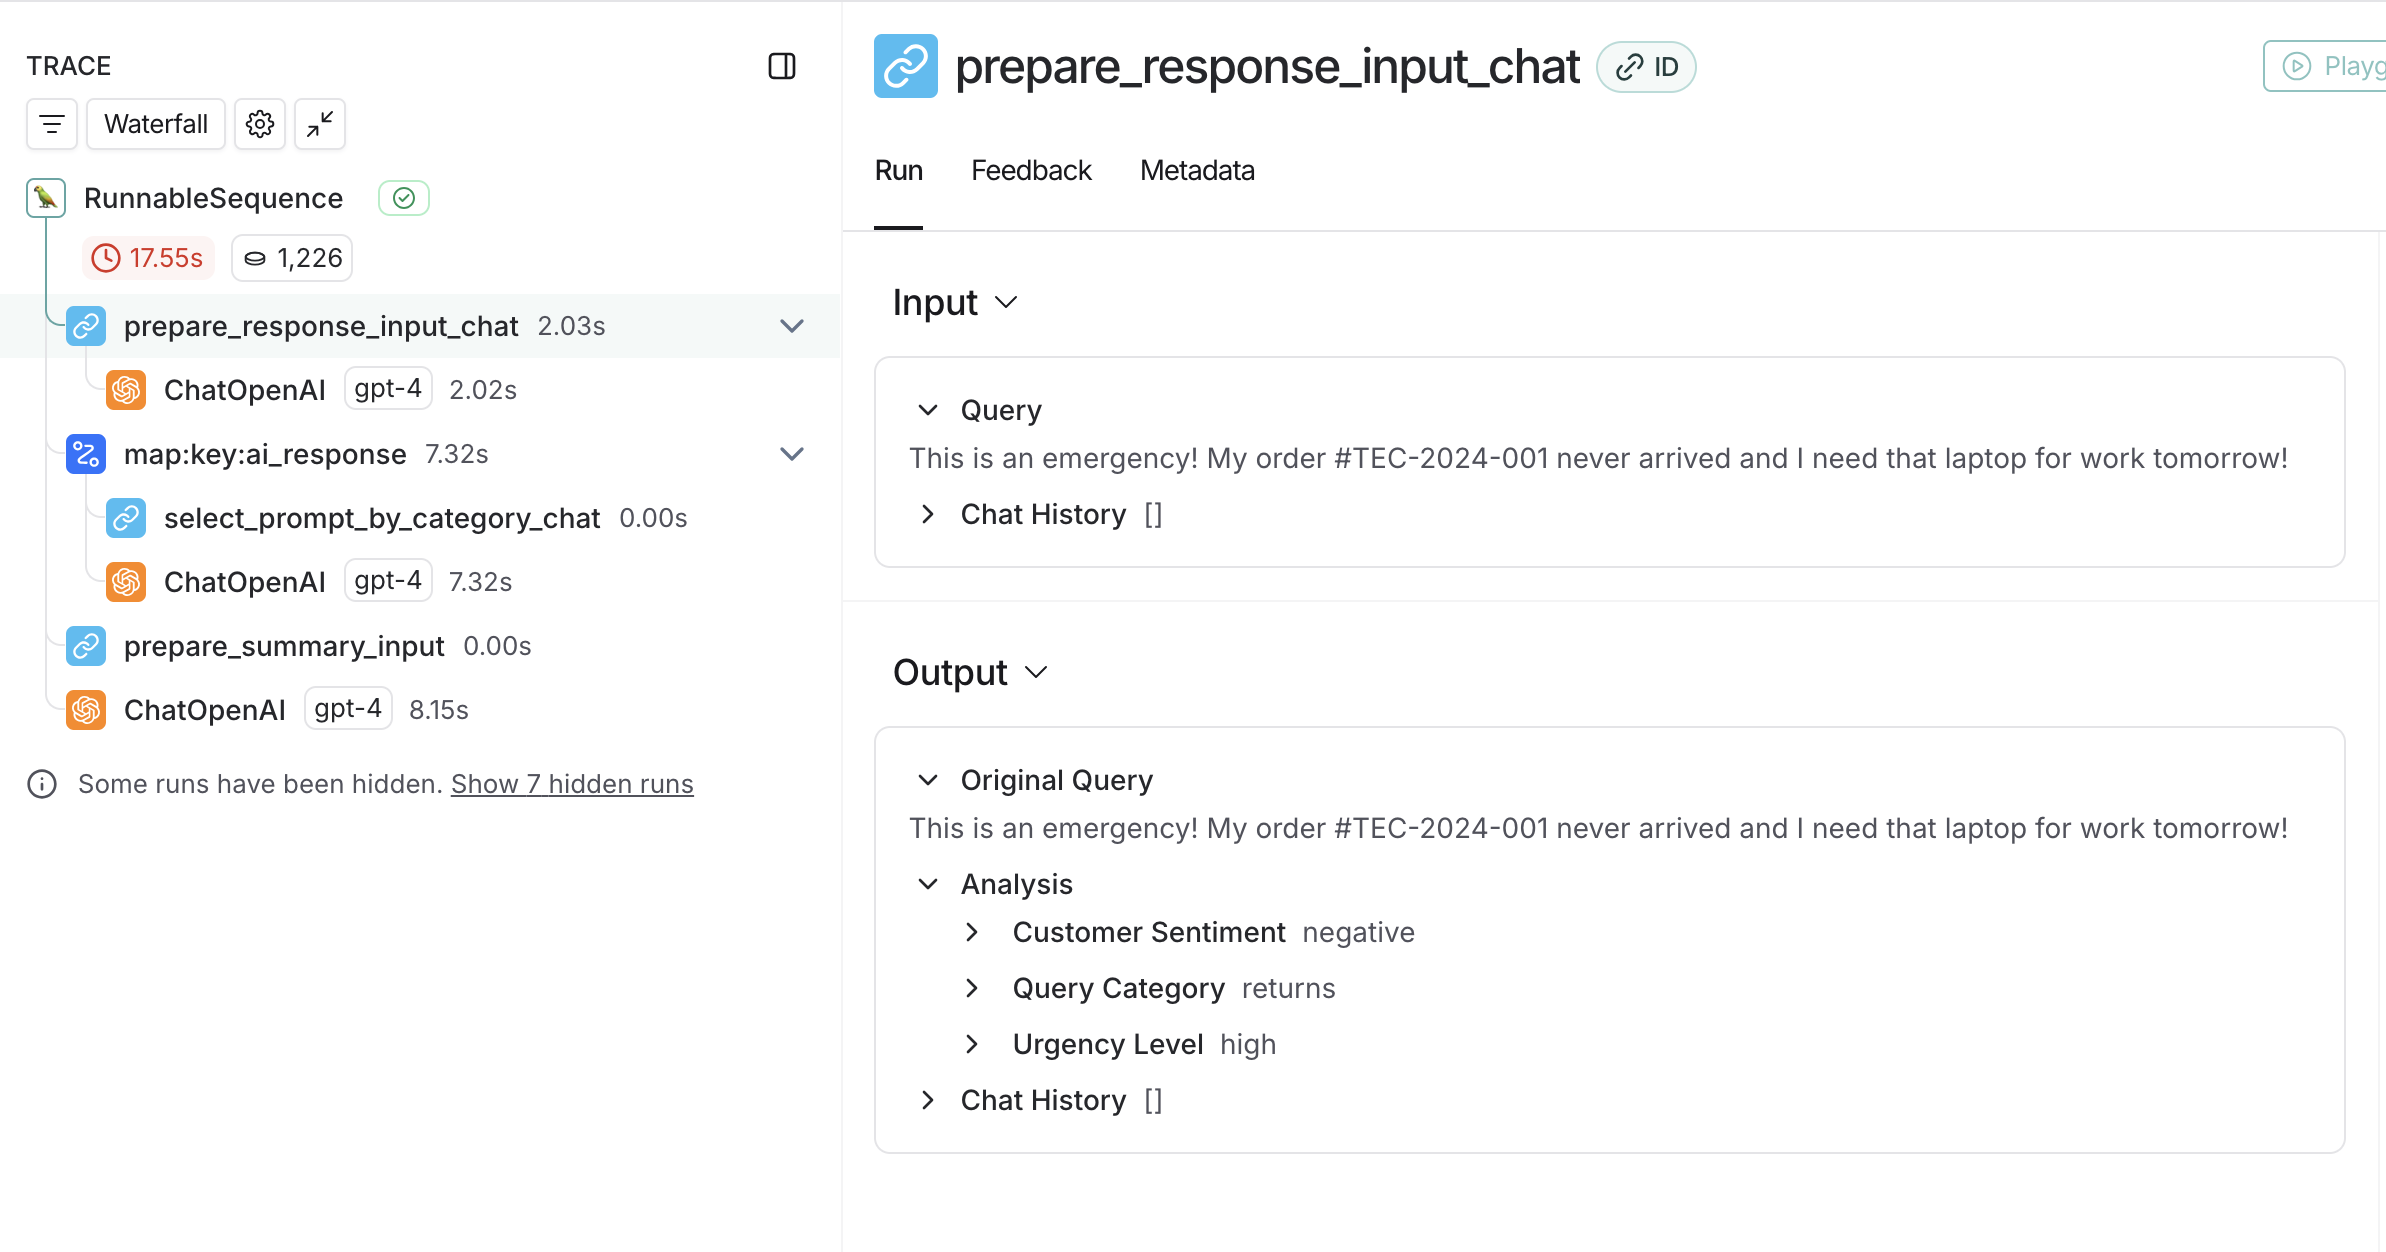
- Luego esto va a la funcion que mapea la respuesta y selecciona el prompt y en base a eso llama a openAI con el prompt correcto
salida de la funcion:
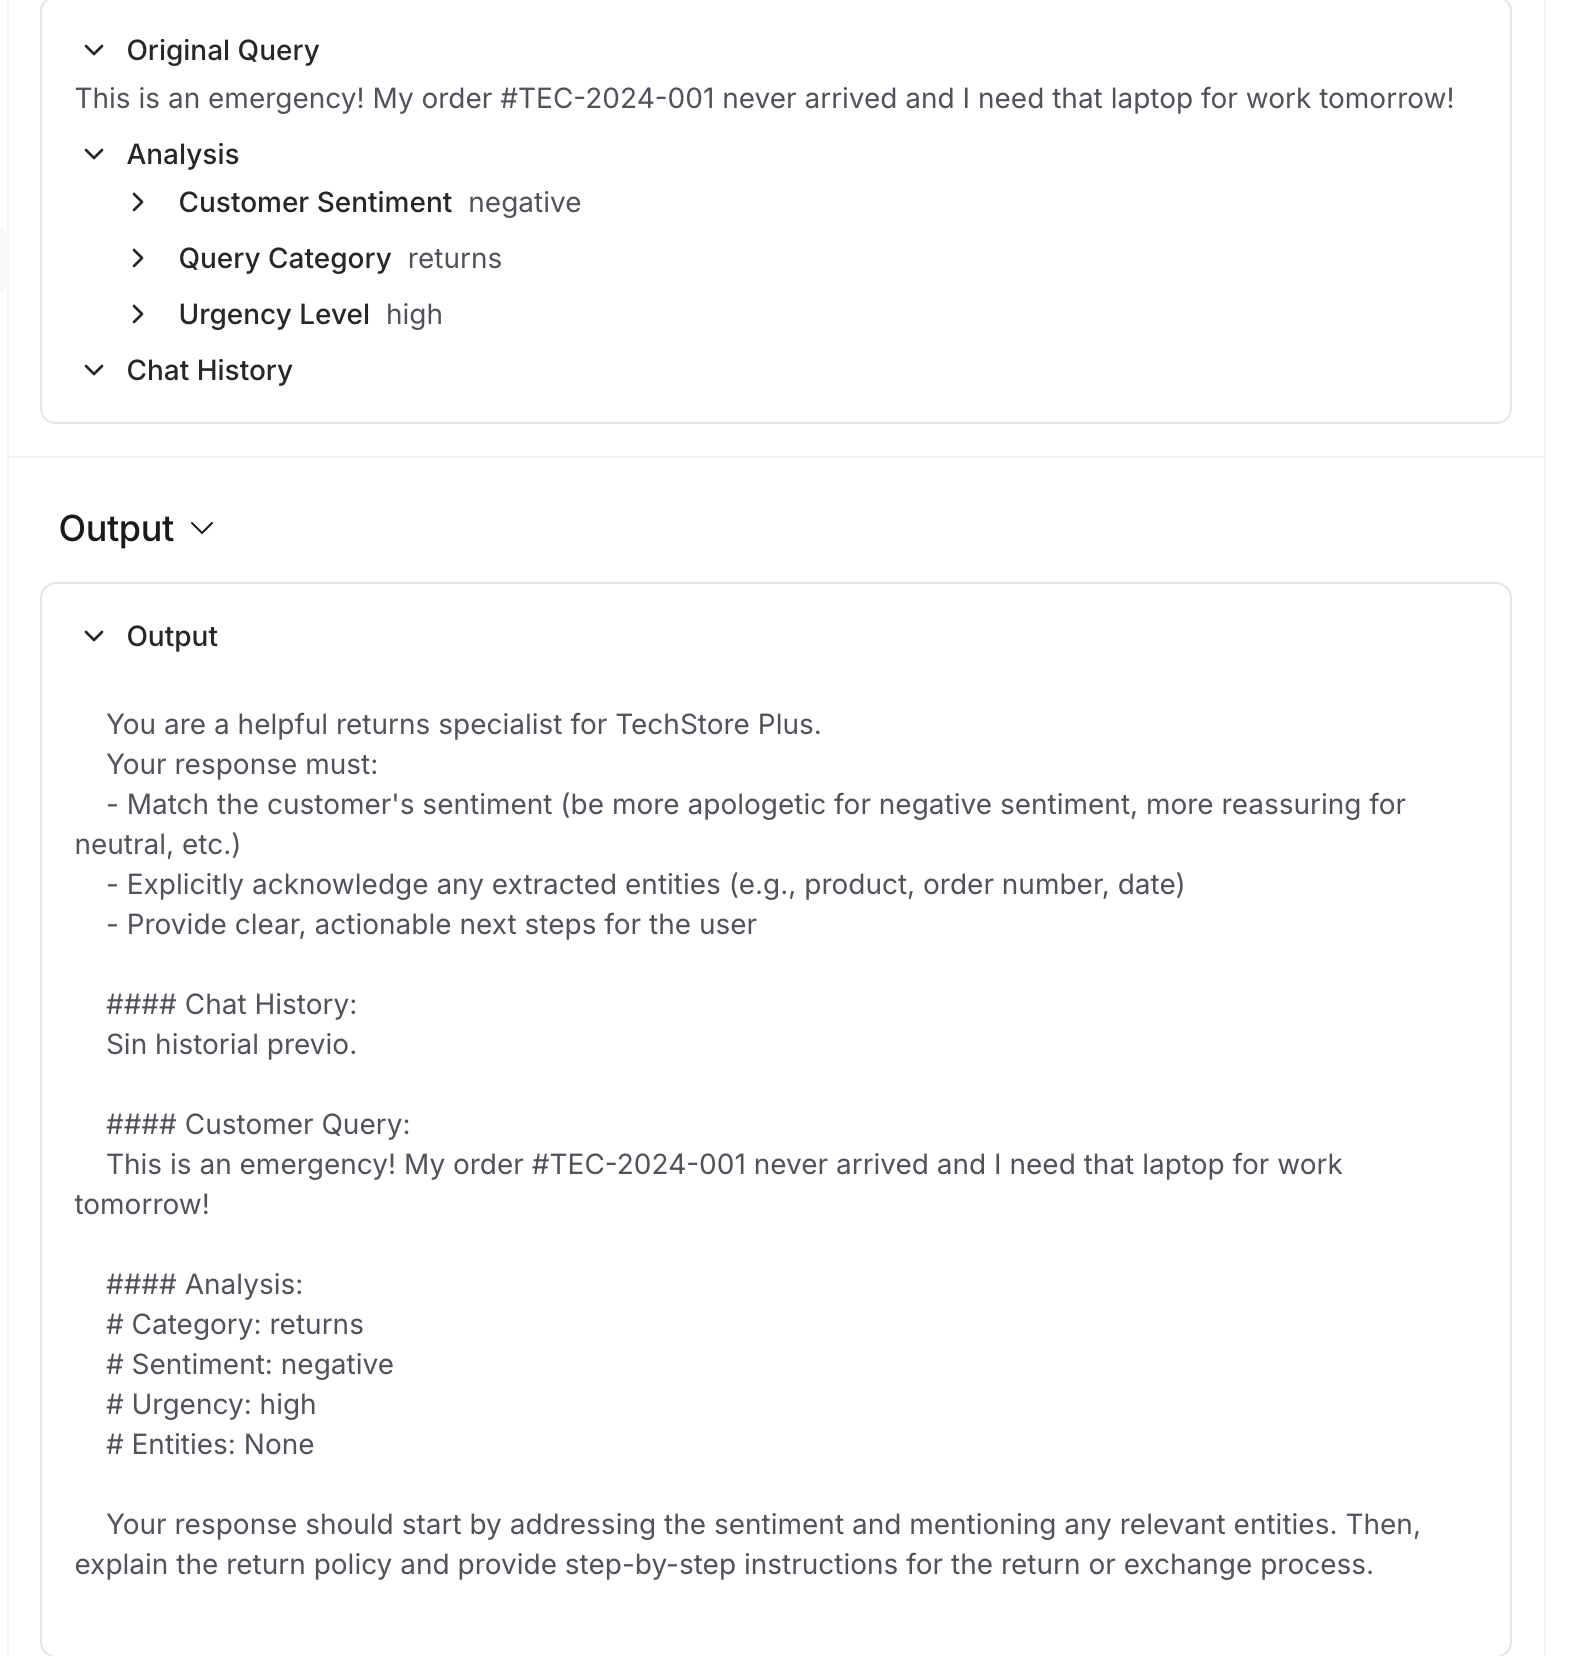
salida del modelo:
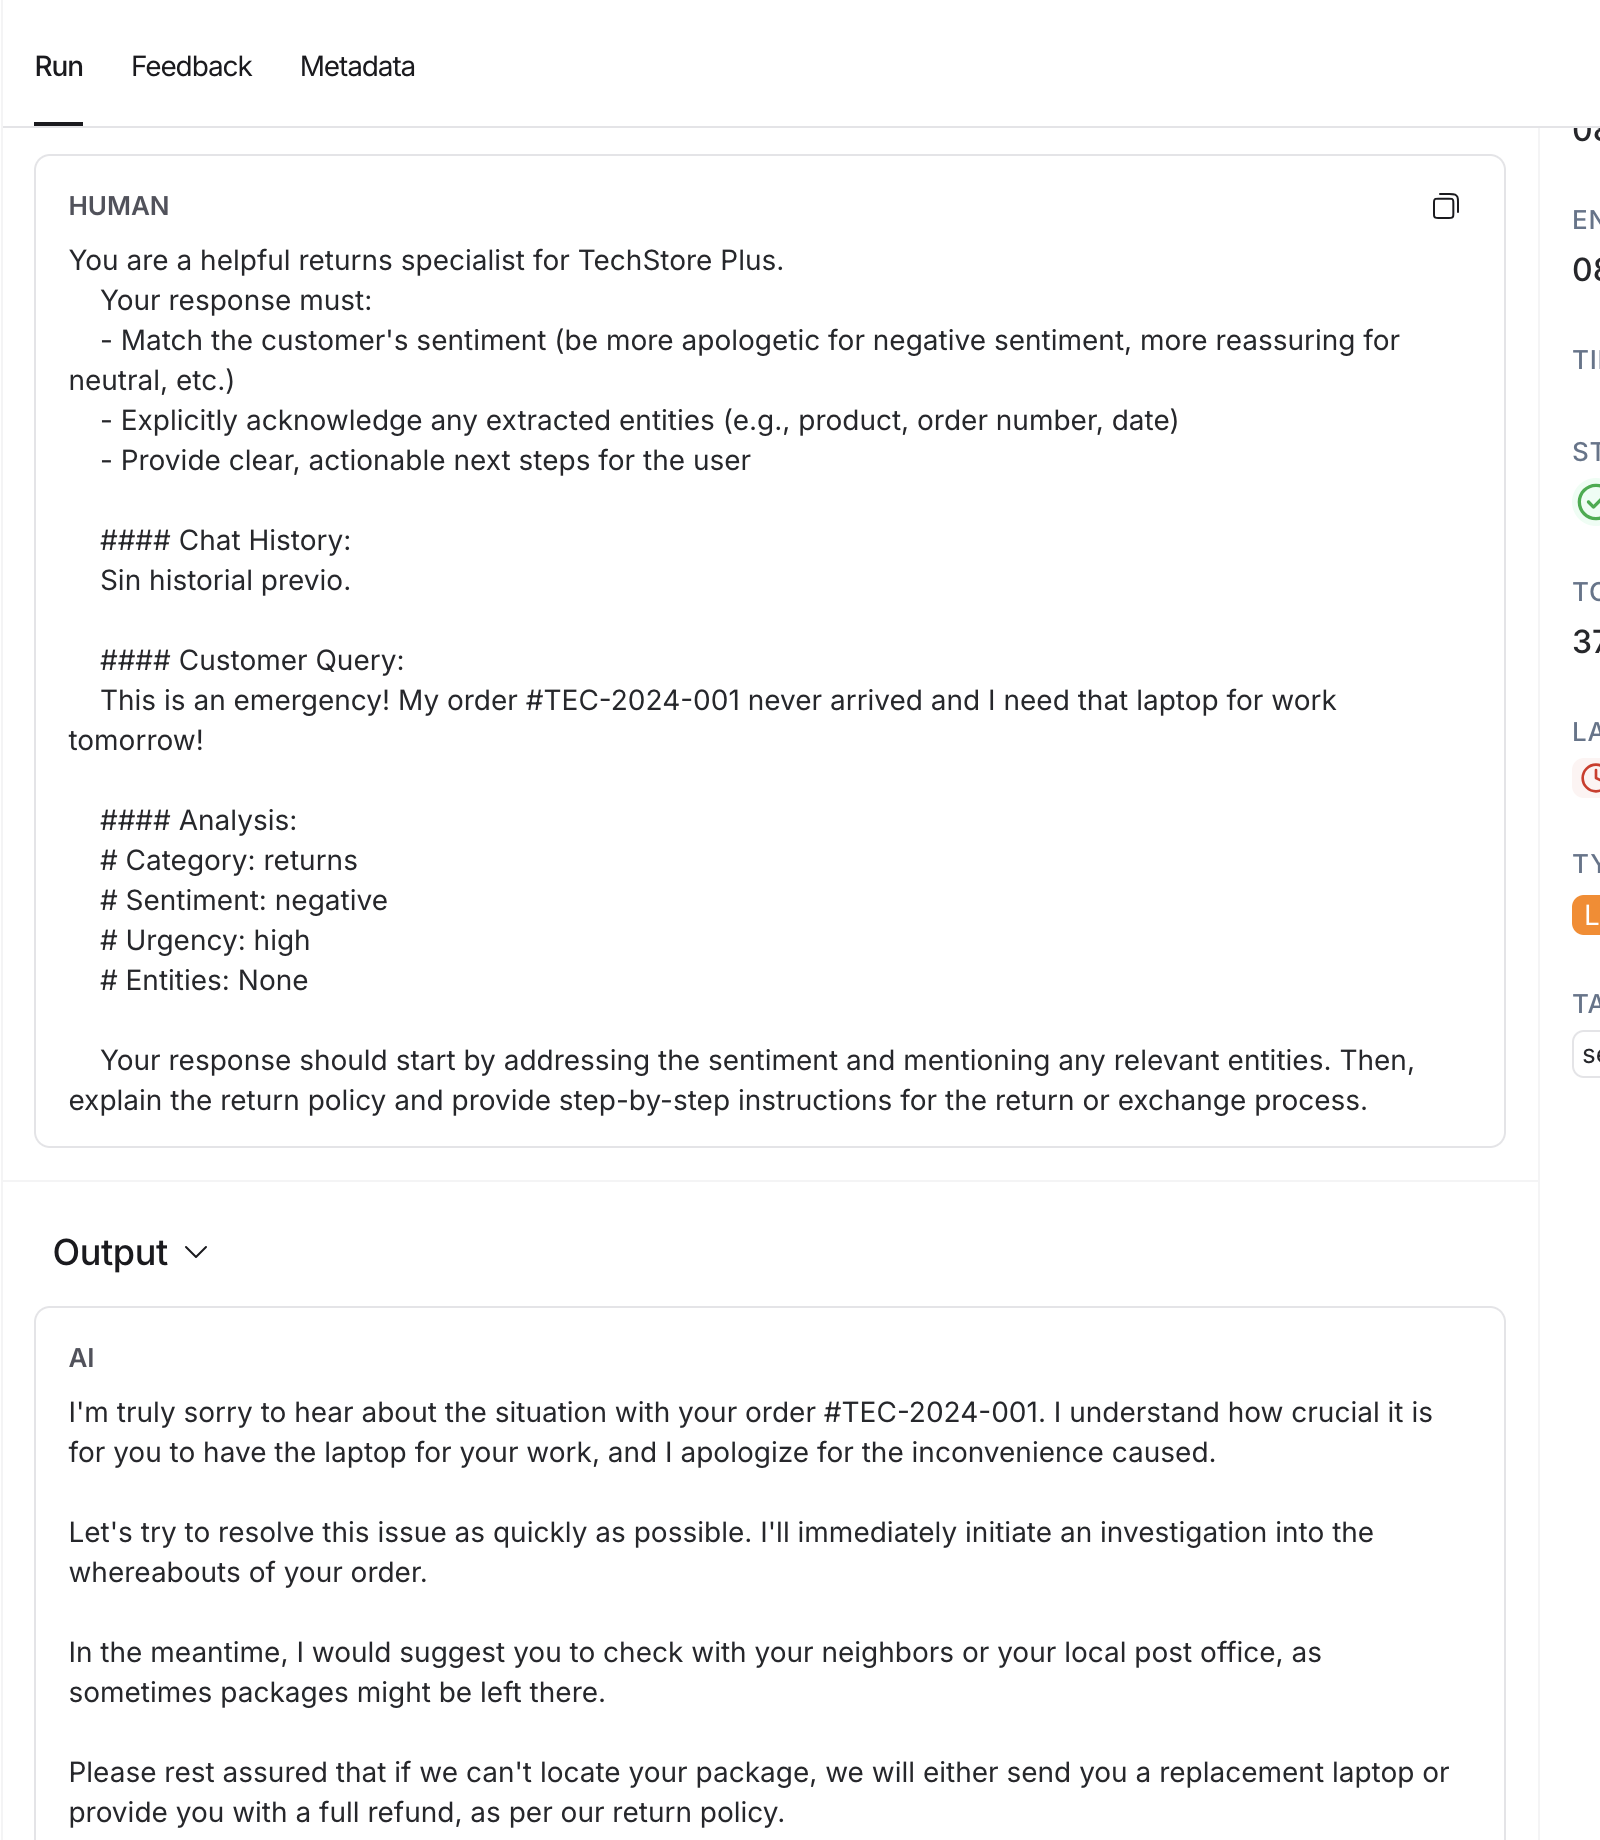
-por ultimo va al paso de preparar el summary de la interaccion
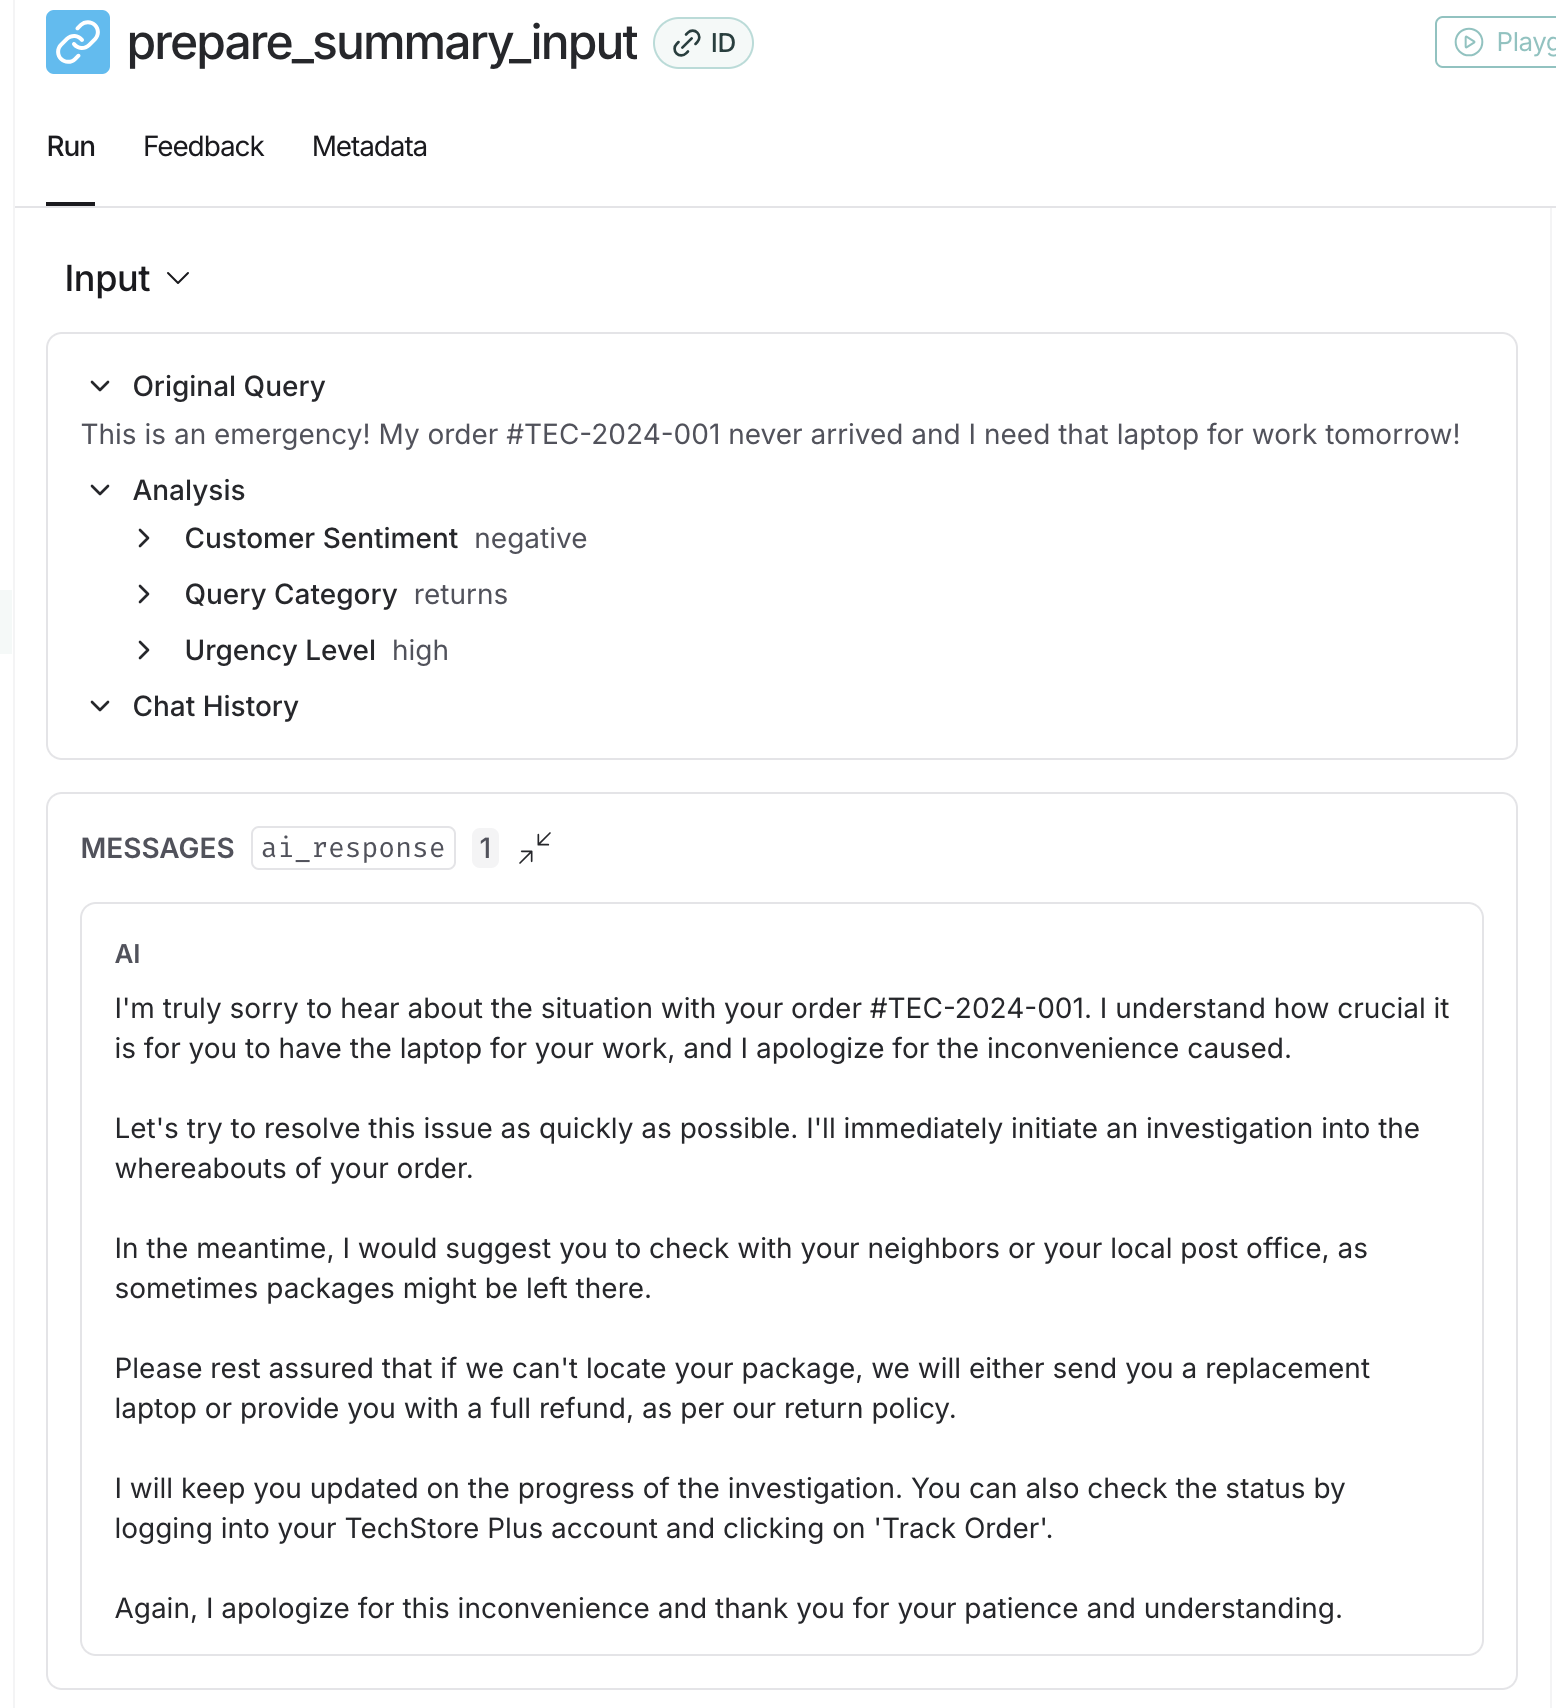
donde tambien llama al mdoelo de openAI quien como output devuelve algo estructurado como pedimos con pydantinc
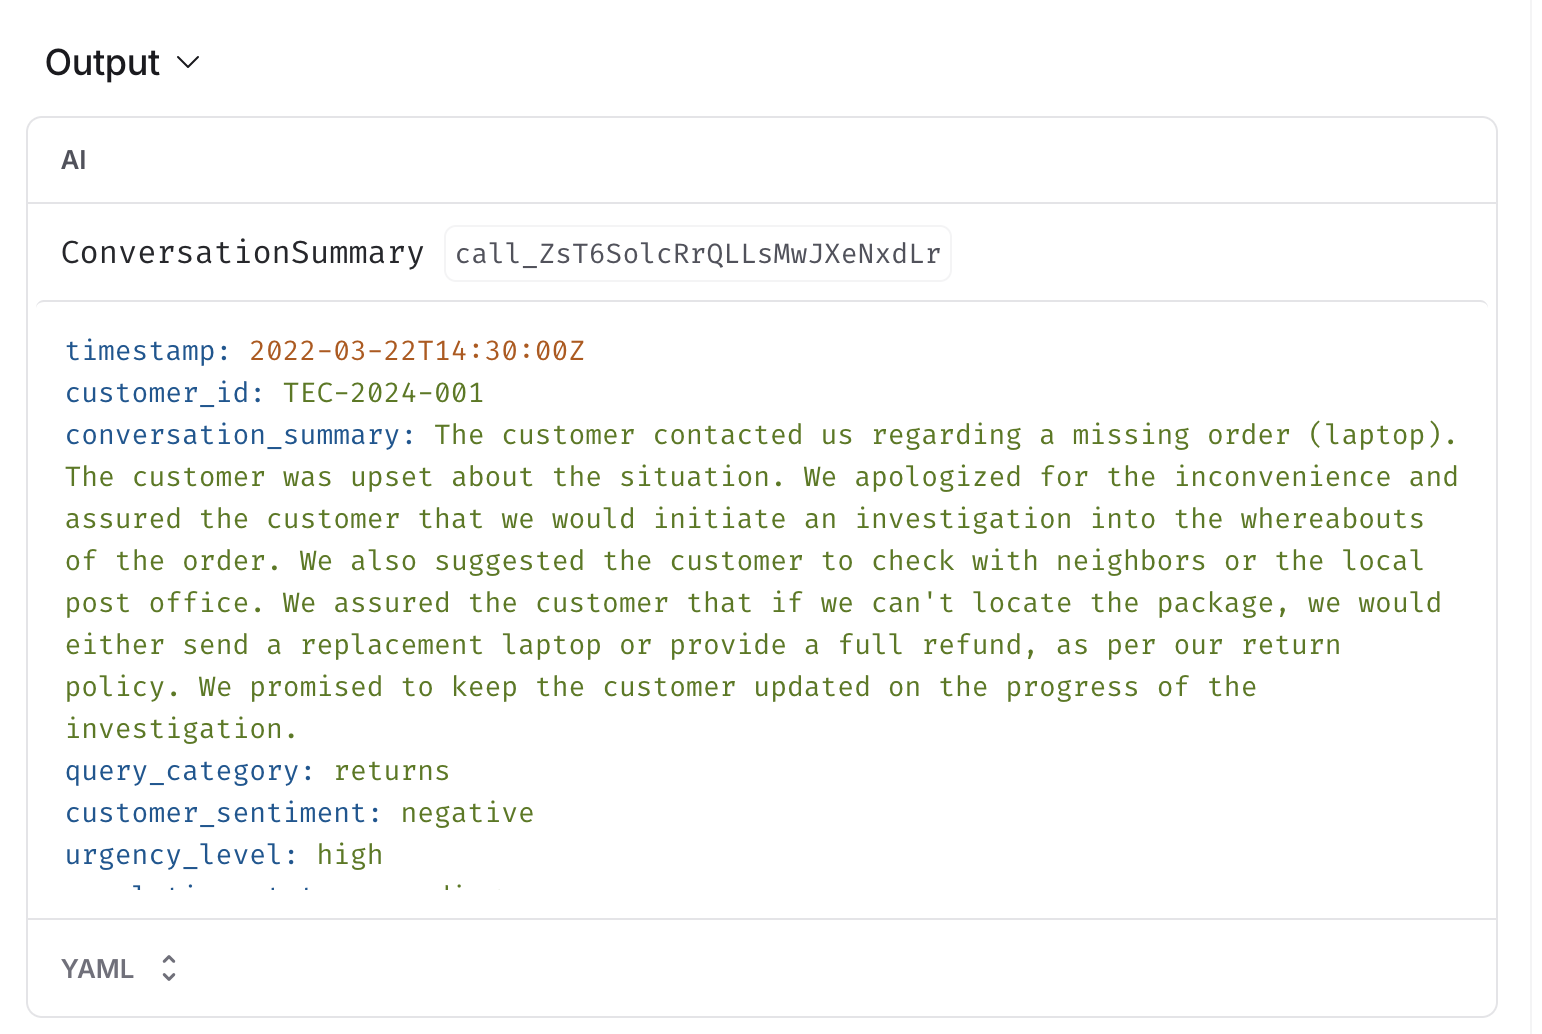


#### Adjunto trace por si se rompen las imagenes 
[LangSmith](https://smith.langchain.com/public/956af86e-6fc4-414a-88ac-3da34d2dc5e7/r)